In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import os

from parser import parse_filename, natural_sort
import pandas as pd

In [86]:
T, rs = 1500, 1.4
nicknames = ['benchmark']
files = []
for n in nicknames:
    files += glob("/data/wanglei/hydrogen/"+n+"/n_14_dim_3_rs_%g*_T_%g*spsize_*tpsize_*mcsteps_*/data.txt"%(rs, T))
files = list(filter(lambda f: os.path.getsize(f)!=0, files))
files = natural_sort(files)
len(files)

4

/data/wanglei/hydrogen/benchmark/n_14_dim_3_rs_1.4_T_1500_steps_1_depth_2_spsize_16_tpsize_16_Nf_5_Gmax_15_kappa_10_mctherm_10_mcsteps_50_mcstddev_0.05_lr_0.01_decay_0.01_damping_0.001_norm_0.001_clip_5_bs_1024_devices_1_accsteps_1/data.txt 3 1.4 1500.0 1 2 16 16 1024 1 0.01 0.001 0.001
/data/wanglei/hydrogen/benchmark/n_14_dim_3_rs_1.4_T_1500_steps_1_depth_3_spsize_16_tpsize_16_Nf_5_Gmax_15_kappa_10_mctherm_10_mcsteps_50_mcstddev_0.05_lr_0.01_decay_0.01_damping_0.001_norm_0.001_clip_5_bs_1024_devices_1_accsteps_1/data.txt 3 1.4 1500.0 1 3 16 16 1024 1 0.01 0.001 0.001
/data/wanglei/hydrogen/benchmark/n_14_dim_3_rs_1.4_T_1500_steps_1_depth_3_spsize_16_tpsize_16_Nf_5_Gmax_15_kappa_10_mctherm_10_mcsteps_50_mcstddev_0.05_lr_0.001_decay_0.01_damping_0.001_norm_0.001_clip_5_bs_1024_devices_1_accsteps_1/data.txt 3 1.4 1500.0 1 3 16 16 1024 1 0.001 0.001 0.001
/data/wanglei/hydrogen/benchmark/n_14_dim_3_rs_1.4_T_1500_steps_1_depth_3_spsize_32_tpsize_16_Nf_5_Gmax_15_kappa_10_mctherm_10_mcsteps

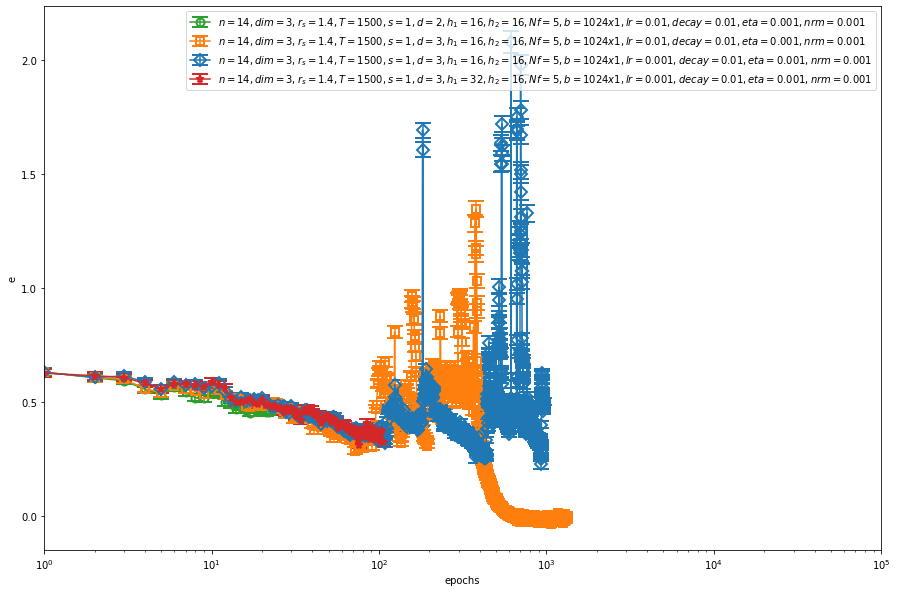

In [89]:
obs = 'e'

markers = ['o', 's', 'D', '*', 'x', '^', '<', 'h', '>', 'd', 'X', 'v', 'h', '1']
colors = ['C2', 'C1','C0', 'C3', 'C4', 'C6', 'C5', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13']

plt.figure(figsize=(15,10))
for f, marker, color in zip(files, markers, colors):
    n, dim, rs, T, s, d, h1, h2, b, a, lr, decay, eta, maxnorm, Nf = parse_filename(f)
    print  (f, dim, rs, T, s, d, h1, h2, b, a, lr, eta, maxnorm)
    df = pd.read_csv(f, delimiter=r"\s+", 
                               names=['epoch', 
                                  'f', 'f_err',
                                  'e', 'e_err',
                                  'k', 'k_err',
                                  'vpp', 'vpp_err',
                                  'vep', 'vep_err',
                                  'vee', 'vee_err',
                                  'p', 'p_err', 
                                  's', 's_err',
                                  'acc_s', 'acc_x'
                                 ])
    
    label = r'$n=%s,dim=%s,r_s=%s,T=%g,s=%s,d=%s,h_1=%s,h_2=%s,Nf=%s,b=%sx%s,lr=%s,decay=%s,eta=%s,nrm=%s$'\
                %(n,dim,rs,T,s,d,h1,h2,Nf,b,a,lr,decay,eta,maxnorm)
    plt.errorbar(df['epoch'].values, df[obs].values, yerr=df[obs+'_err'].values,
                 marker=marker, color=color,markerfacecolor='none', 
                 markeredgewidth=2, ms=8, capsize=8, label=label)

    
plt.legend(loc='best')
plt.ylabel(obs)
plt.xlabel('epochs')
#plt.ylim([6.8, 7])
#plt.ylim([-0.16, -0.10])
plt.xlim([1, 1e5])
plt.xscale('log') 